# The goal is to access and prepare text data to train a model to act as a chatbot regarding any desired category
##### Disclaimer: This is being done on a single machine so the model is not going to be well trained

## Import the necessary libraries

In [1]:
import re
import nltk
import math
import time
import torch
import string
import pynvml
import logging
import requests
import seaborn as sns
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
from bs4 import BeautifulSoup
import pytorch_lightning as pl
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datasets import load_dataset
from nltk.corpus import stopwords
from tokenizers.models import WordLevel
from typing import Union, Optional, Callable
from torch.cuda.amp import GradScaler, autocast
from tokenizers.trainers import WordLevelTrainer
from tokenizers import Tokenizer, pre_tokenizers
from torch.utils.data.dataloader import default_collate
from generic_transformer import build_transformer, Transformer
from torch.utils.data import Dataset, DataLoader, random_split, dataset
from torch.optim.lr_scheduler import StepLR, CyclicLR, CosineAnnealingLR
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW, logging as hf_logging, get_linear_schedule_with_warmup

## Configure Notebook Settings

In [2]:
sns.set()
hf_logging.set_verbosity_error()
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amram\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Create a logger

In [3]:
def create_logger(name: str, file: str, log_name: str):
    # Create the logger object
    logger = logging.getLogger(name)

    # Set the level of the logger object to DEBUG
    logger.setLevel(logging.DEBUG)

    # Create a formatter object for the logger object
    formatter = logging.Formatter('%(asctime)s:%(levelname)s:%(name)s:%(message)s')

    # Ensure that parent directory exists
    if not Path(file).parent.parent.joinpath('Logs').exists():
        Path(file).parent.parent.joinpath('Logs').mkdir(parents=True, exist_ok=True)

    # Create error and info level logging file handlers, as well as a stream (console) handler and apply the formatter
    error_logging_file = Path(file).parent.joinpath(f'Logs\{log_name}_Errors.log')
    info_logging_file = Path(file).parent.joinpath(f'Logs\{log_name}_Info.log')
    error_file_handler = logging.FileHandler(error_logging_file)
    info_file_handler = logging.FileHandler(info_logging_file)
    error_file_handler.setLevel(logging.ERROR)
    info_file_handler.setLevel(logging.INFO)
    error_file_handler.setFormatter(formatter)
    info_file_handler.setFormatter(formatter)
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.DEBUG)
    stream_handler.setFormatter(formatter)
    logger.addHandler(error_file_handler)
    logger.addHandler(info_file_handler)
    logger.addHandler(stream_handler)
    return logger

In [4]:
logger = create_logger('TransformerChatbot', './TransformerChatbot.py', 'TransformerChatbot')

## Automated text data retrieval from gutenberg

In [5]:
def get_subcategory_link(url: str, subcategory: str, logger: logging.Logger):
    # Send a GET request to the genre page
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content of the genre page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the subcategory link that matches the query
        subcategory_link_tag = soup.find('a', href=True, string=lambda text: text and subcategory.lower() in text.lower())

        # If the subcategory link was found, return the corresponding url, else log a list of available subcategories
        if subcategory_link_tag:
            subcategory_url = 'https://www.gutenberg.org' + subcategory_link_tag['href']
            return subcategory_url
        else:
            subcategory_links = soup.find_all('a', href=True)
            for link in subcategory_links:
                href = link['href']
                text = link.get_text(strip=True)
                if href and text:
                    logger.info(f"Available Options: {text}, Href: https://www.gutenberg.org{href}")

            raise ValueError(f"No subcategory link found for query: {subcategory}")
    else:
        raise ValueError(f"No subcategory link found for query: {subcategory}")


def get_book_links(subcategory_url: str, logger: logging.Logger):
    # When sending a GET request to the subcategory_url, there will be 25 books per page starting with an index of 1
    start_index = 1

    # This dictionary will keep track of all the download links and which books they are corresponding to
    txt_file_links = {}

    # I want to keep going to the next page of 25 books until there is no more books
    while True:
        # If this is the first page, the url will be the subcategory_url.
        if start_index == 1:
            paginated_url = f"{subcategory_url}"

        # Otherwise, the start_index query string must be included
        else:
            paginated_url = f"{subcategory_url}?start_index={start_index}"

        # Send a GET request to the paginated url
        response = requests.get(paginated_url)

        if response.status_code == 200:
            logger.info(f'Accessed {paginated_url}')

            # parse the html of the webpage in order to find the book links
            soup = BeautifulSoup(response.content, 'html.parser')
            book_links = soup.find_all('li', class_='booklink')

            # If no more book links are found, break the loop
            if not book_links:
                break

            # Loop through the book links and extract the title and author of the book, as well as the download link
            for i, book in enumerate(book_links):
                title_tag = book.find('span', class_='title')
                subtitle_tag = book.find('span', class_='subtitle')

                if title_tag and subtitle_tag:
                    title = title_tag.text
                    author = subtitle_tag.text

                    book_page_link = 'https://www.gutenberg.org' + book.find('a')['href']
                    book_response = requests.get(book_page_link)
                    if book_response.status_code == 200:
                        book_soup = BeautifulSoup(book_response.content, 'html.parser')
                        txt_link_tag = book_soup.find('a', href=True, string='Plain Text UTF-8')
                        if txt_link_tag:
                            txt_file_link = txt_link_tag['href']
                            txt_file_links[f'{title}_{author}'] = txt_file_link
                        else:
                            logger.info(f'No .txt link found for book {i + 1}')
                    else:
                        logger.info(f"Failed to retrieve the book page for book {i + 1}. Status code: {book_response.status_code}")
                else:
                    logger.info(f'Title or author not found for book {i + 1}')

            if len(book_links) < 25:
                break

            start_index += 25
        else:
            raise ValueError(f"No subcategory link found for query: {subcategory} - Status code: {response.status_code}")

    return txt_file_links


def get_sentences(txt_links: dict, logger: logging.Logger, intro_pct: float = 0.10):
    # A list of strings will be returned for each book found in the subcategory library in project gutenberg
    all_sentences = []

    for link in txt_links.values():
        # Construct the full URL
        full_url = 'https://www.gutenberg.org' + link

        # Fetch the .txt file content
        response = requests.get(full_url)
        if response.status_code == 200:
            content = response.text

            # Tokenize the text into words
            words = nltk.word_tokenize(content)

            # Remove the first and last 10% of the words as intro and appendix, respectively
            remaining_words = words[int(intro_pct * len(words)):-int(intro_pct * len(words))]

            # Join the remaining words back into a string
            text = ' '.join(remaining_words)

            # Remove project gutenberg out of the text since it occurs so often
            remaining_text = re.sub('project gutenberg', '', text, flags=re.IGNORECASE)
            remaining_text = re.sub('gutenberg', '', text, flags=re.IGNORECASE)

            # Split the remaining text into sentences
            sentences = nltk.sent_tokenize(remaining_text)

            # Add the sentences to the list of all sentences
            all_sentences.extend(sentences)
        else:
            print(f"Failed to retrieve the .txt file from {full_url}. Status code: {response.status_code}")

    return all_sentences


def get_text_data(subcategory: str, logger: logging.Logger):
    # Start off with project gutenberg's bookshelf
    url = 'https://www.gutenberg.org/ebooks/bookshelf/'

    # Get the link to the desired subcategory page
    subcategory_url = get_subcategory_link(url=url, subcategory=subcategory, logger=logger)

    if subcategory_url:
        # Get the list of book .txt file links from the subcategory page
        txt_links = get_book_links(subcategory_url=subcategory_url, logger=logger)

        # Get all sentences from the list of .txt file links
        all_sentences = get_sentences(txt_links=txt_links, logger=logger)

        # Print the number of sentences and the first few sentences as a sample
        logger.info(f"Total number of sentences: {len(all_sentences)}")
        return txt_links, all_sentences
    else:
        logger.warning("Failed to find subcategory link.")

In [6]:
load_data_time = time.time()
txt_links, all_sentences = get_text_data(subcategory='World War II', logger=logger)
print(f'Loading data took {time.time() - load_data_time:.2f} seconds')

2024-06-11 19:49:04,020:INFO:TransformerChatbot:Accessed https://www.gutenberg.org/ebooks/bookshelf/325
2024-06-11 19:49:07,430:INFO:TransformerChatbot:Title or author not found for book 9
2024-06-11 19:49:12,949:INFO:TransformerChatbot:Title or author not found for book 24
2024-06-11 19:49:13,717:INFO:TransformerChatbot:Accessed https://www.gutenberg.org/ebooks/bookshelf/325?start_index=26
2024-06-11 19:49:26,342:INFO:TransformerChatbot:Accessed https://www.gutenberg.org/ebooks/bookshelf/325?start_index=51
2024-06-11 19:49:37,353:INFO:TransformerChatbot:Accessed https://www.gutenberg.org/ebooks/bookshelf/325?start_index=76
2024-06-11 19:50:54,415:INFO:TransformerChatbot:Total number of sentences: 261157


Loading data took 111.38 seconds


In [7]:
txt_links

{'The Homing Pigeon_United States. War Department and United States. Army. Signal Corps': '/ebooks/55084.txt.utf-8',
 'Motorcycle, Solo (Harley-Davidson Model WLA)_United States. War Department': '/ebooks/51058.txt.utf-8',
 'Closing In: Marines in the Seizure of Iwo Jima_Joseph H. Alexander': '/ebooks/49080.txt.utf-8',
 'Across the Reef: The Marine Assault of Tarawa_Joseph H. Alexander': '/ebooks/48836.txt.utf-8',
 'Portable Flame Thrower M2-2_United States. War Department': '/ebooks/53669.txt.utf-8',
 'Blesky nad Beskydami (Czech)_František Omelka': '/ebooks/47754.txt.utf-8',
 'Integration of the Armed Forces, 1940-1965_Morris J. MacGregor': '/ebooks/20587.txt.utf-8',
 'Leyte: The Return to the Philippines_M. Hamlin Cannon': '/ebooks/48991.txt.utf-8',
 'First Offensive: The Marine Campaign for Guadalcanal_Henry I. Shaw': '/ebooks/48807.txt.utf-8',
 'Bloody Beaches: The Marines at Peleliu_Gordon D. Gayle': '/ebooks/49032.txt.utf-8',
 'Trial of the Major War Criminals Before the Interna

In [8]:
all_sentences

['feathers , hair feathers , fluff feathers , and down feathers .',
 '_a._ CONTOUR FEATHERS .',
 'Contour feathers are large feathers covering the pigeon ’ s body .',
 'When the bird is not in flight or excited , they lie close to its body , normally overlapping and presenting a smooth outer surface .',
 'The larger ones are the flight and tail feathers .',
 'The average pigeon has 12 main tail feathers ; on each wing there are 10 primary flights and 12 secondary flights .',
 'The bases of these large feathers are covered by shorter feathers called coverts .',
 'These give a rounded , smooth , and continuous line to the body .',
 'The main tail feathers act as a rudder in flight , controlling the bird ’ s direction .',
 'Flying is possible because every flight feather overlaps , presenting a solid surface on the downbeat of the wing .',
 'Besides , flight feathers provide lift and pull for the bird ’ s propulsion .',
 'On the upbeat of the wing , the large flight feathers rotate in suc

## Run preliminary analytics on the unprocessed text data

In [9]:
def word_analytics(sentences: list, width: int = 800, height: int = 400, background_color: str = 'white'):
    # Load all the stop words from the ntlk corpus and remove them from the dataset temporarily for analysis
    remove_time = time.time()
    stop_words = set(stopwords.words('english'))
    text = [(word, len(word)) for sentence in sentences for word in sentence.split(' ') if word not in stop_words]
    
    # Build a wordcloud to visualize the most common words
    tokenize_time = time.time()
    tokens = nltk.word_tokenize(' '.join([word for word, _ in text]))    
    processed_text = ' '.join(tokens)
    generation_time = time.time()
    wordcloud = WordCloud(width=width, height=height, background_color=background_color).generate(processed_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # Build a word distribution in order to determine a good sequence length
    sequence_time = time.time()
    sequence_lengths = [length for _, length in text]
    
    fig, ax = plt.subplots()
    ax.hist(sequence_lengths, bins=50)
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Frequency')
    plt.show()

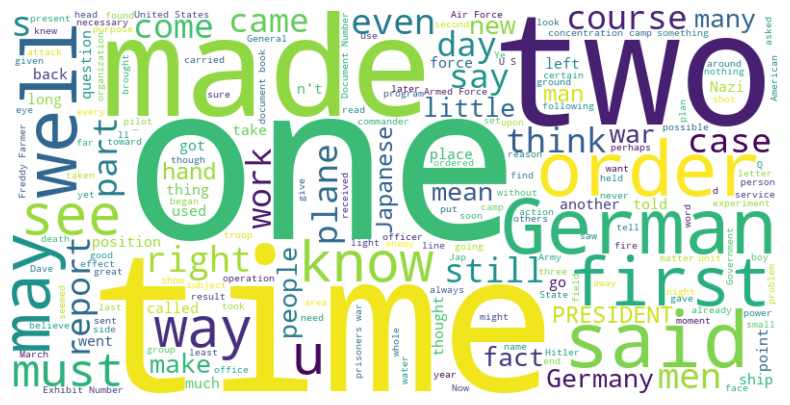

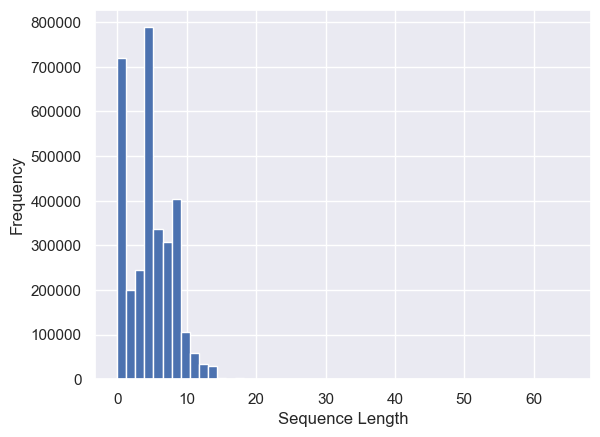

In [10]:
word_analytics(sentences=all_sentences)

## Build the Transformer Model

### Define activation functions

#### Relu (Rectified Linear Unit):
$Relu(x) = max(0, x)$


#### Softmax: 
$softmax(z_i) = \frac{e^{z_i}}{\sum^n_{j=1}e^{z_j}}$

In [11]:
def relu(x: torch.Tensor):
    return torch.max(x, torch.tensor(0.0))


def softmax(x: torch.Tensor, dim: int = -1):
    max_val, _ = torch.max(x, dim=dim, keepdim=True)
    x_exp = torch.exp(x - max_val)
    sum_x_exp = torch.sum(x_exp, dim=dim, keepdim=True)
    return x_exp / sum_x_exp

### Define the layers of the Transformer model
Input -> Tokenization -> Encoder -> Decoder -> Projection -> Output

N Encoder Blocks: Source Embedding -> Positional Encoding -> Residual Connection -> Layer Normalization -> h Multihead Attention Blocks -> Residual Connection -> Layer Normalization -> Feed Forward -> repeat N times -> Encoder Output

N Decoder Blocks: Target Embedding -> Positional Encoding -> Residual Connection -> Layer Normalization -> h Multihead Attention Blocks -> Residual Connection -> Layer Normalization -> h Cross Attention Blocks -> Feed Forward -> repeat N times -> Decoder Output

In [12]:
# Use Low Rank Adaptation to improve runtime efficiency
class LoRALayer(nn.Module):
    def __init__(self, original_layer: nn.Module, r: int):
        super().__init__()
        self.original_layer = original_layer
        self.r = r
        self.lora_A = nn.Linear(original_layer.in_features, r, bias=False)
        self.lora_B = nn.Linear(r, original_layer.out_features, bias=False)
        nn.init.xavier_uniform_(self.lora_A.weight)
        nn.init.zeros_(self.lora_B.weight)

    def forward(self, *inputs):
        original_output = self.original_layer(*inputs)
        x = inputs[0]
        lora_A_output = self.lora_A(x)
        lora_B_output = self.lora_B(lora_A_output)

        if isinstance(original_output, tuple):
            modified_output = tuple((original + lora_B_output) for original in original_output)
        else:
            modified_output = original_output + lora_B_output

        return modified_output
        
class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x: torch.Tensor):
        return self.embedding(x) * math.sqrt(self.d_model)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -math.log(10000) / d_model)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)


class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x: torch.Tensor):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.alpha * ((x - mean) / torch.sqrt(std + self.eps)) + self.bias


class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float):
        super().__init__()
        self.in_features = d_model
        self.out_features = d_model
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x: torch.Tensor):
        return self.linear_2(self.dropout(relu(self.linear_1(x))))


class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float):
        super().__init__()
        self.in_features = d_model
        self.out_features = d_model
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, 'd_model is not divisible by h'
        self.d_k = d_model // h
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self._attention_scores = None

    @property
    def attention_scores(self):
        return self._attention_scores

    @attention_scores.setter
    def attention_scores(self, attention_scores: torch.Tensor):
        self._attention_scores = attention_scores

    def attention(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: Optional[torch.Tensor]):
        d_k = query.shape[-1]
        attention_scores = ((query @ key.transpose(-2, -1)) / (math.sqrt(d_k)))

        if mask is not None:
            mask = mask.to(torch.bool)  # Ensure mask is boolean
            mask = mask.expand_as(attention_scores)  # Expand mask dimensions
            attention_scores = attention_scores.float()  # Ensure attention scores are float32
            attention_scores.masked_fill_(mask == 0, -1e9)

        attention_scores = softmax(attention_scores, dim=-1)

        if self.dropout is not None:
            attention_scores = self.dropout(attention_scores)

        return attention_scores @ value, attention_scores

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, mask: Optional[torch.Tensor]):
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)
        x, self.attention_scores = self.attention(query, key, value, mask)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        return self.w_o(x)


class ResidualConnection(nn.Module):
    def __init__(self, dropout: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()

    def forward(self, x: torch.Tensor, sublayer: Callable):
        return x + self.dropout(sublayer(self.norm(x)))


class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float, r: int):
        super().__init__()
        if r > 0:
            self.self_attention_block = LoRALayer(self_attention_block, r)
            self.feed_forward_block = LoRALayer(feed_forward_block, r)
        else:
            self.self_attention_block = self_attention_block
            self.feed_forward_block = feed_forward_block
        
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])
            
    def forward(self, x: torch.Tensor, src_mask: Optional[torch.Tensor]):
        x = self.residual_connections[0](x, lambda x_i: self.self_attention_block(x_i, x_i, x_i, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x


class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None):
        for layer in self.layers:
            x = layer(x, mask)

        return self.norm(x)


class DecoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float, r: int):
        super().__init__()
        if r > 0:
            self.self_attention_block = LoRALayer(self_attention_block, r)
            self.cross_attention_block = LoRALayer(cross_attention_block, r)
            self.feed_forward_block = LoRALayer(feed_forward_block, r)
        else:
            self.self_attention_block = self_attention_block
            self.cross_attention_block = cross_attention_block
            self.feed_forward_block = feed_forward_block
            
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask: Optional[torch.Tensor], tgt_mask: Optional[torch.Tensor]):
        x = self.residual_connections[0](x, lambda x_i: self.self_attention_block(x_i, x_i, x_i, tgt_mask))
        x = self.residual_connections[1](x, lambda x_j: self.cross_attention_block(x_j, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x


class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask: Optional[torch.Tensor], tgt_mask: Optional[torch.Tensor]):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)

        return self.norm(x)


class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.in_features = d_model
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x: torch.Tensor):
        epsilon = 1e-8
        return torch.log(softmax(self.proj(x), dim=-1) + epsilon)


class Transformer(nn.Module):
    def __init__(
            self,
            encoder: Encoder,
            decoder: Decoder,
            src_embed: InputEmbeddings,
            tgt_embed: InputEmbeddings,
            src_pos: PositionalEncoding,
            tgt_pos: PositionalEncoding,
            projection_layer: ProjectionLayer
    ):

        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src: torch.Tensor, src_mask: Optional[torch.Tensor]):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output: torch.Tensor, src_mask: Optional[torch.Tensor], tgt: torch.Tensor, tgt_mask: Optional[torch.Tensor]):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def forward(self, src: torch.Tensor, tgt: torch.Tensor, src_mask: Optional[torch.Tensor] = None, tgt_mask: Optional[torch.Tensor] = None):
        # Encode the source sequence
        encoder_output = self.encode(src, src_mask)

        # Decode the target sequence
        decoder_output = self.decode(encoder_output, src_mask, tgt, tgt_mask)

        # Project the decoder output to the vocabulary space
        output = self.projection_layer(decoder_output)

        return output

In [13]:
def build_transformer(vocab_size: int, seq_len: int, d_model: int, N: int, h: int, dropout: float, d_ff: int, r: int) -> Transformer:
    # Build the first layer of the encoder and decoder blocks, which is the input embedding
    src_embed = InputEmbeddings(d_model, vocab_size)
    tgt_embed = InputEmbeddings(d_model, vocab_size)

    # Add the second layer of positional encoding to add spatial relationships between tokens
    src_pos = PositionalEncoding(d_model, seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, seq_len, dropout)

    # Build the encoder blocks using multi head self attention and feed forward blocks
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout, r)
        encoder_blocks.append(encoder_block)

    # Build the decoder blocks using multi head self attention, multi head cross attention, and feed forward blocks
    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout, r)
        decoder_blocks.append(decoder_block)

    # Build the transformer model using the encoder, decoder, and projection layer
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))
    projection_layer = ProjectionLayer(d_model, vocab_size)
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize paramters using the xavier glorot uniform initialization
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer

# Here are 3 different decoding methods for the transformer to use

## Nucleus Sampling will be used during training to generate diverse sequences
## Beam Search will be used during validation to evaluate the potentially global optimal quality of the generated sequences 
## Autoregression will be used during inference to generate stable and coherent outputs for end-users

In summary:

- Beam Search: Balances exploration and exploitation by considering multiple sequences but is computationally expensive.
- Nucleus Sampling: Encourages diversity through stochastic sampling from the top-p tokens, leading to varied and creative outputs.
- Autoregressive (Greedy) Decoding: Simple and fast, selecting the most likely token at each step, which can lead to predictable but sometimes less diverse outputs.

In [14]:
def beam_search_decode(model: Transformer, input_tokens: torch.Tensor, seq_len: int, tokenizer: Tokenizer, device: torch.device, num_beams: int = 3):
    model.eval()
    # Initialize the decoding with the start-of-sequence (SOS) token
    sos_token = torch.tensor([tokenizer.token_to_id('[SOS]')], dtype=torch.long, device=device).unsqueeze(0)
    
    # Beam initialization: each beam is a tuple of (decoded tokens, log-probability)
    beams = [(sos_token, 0.0)]

    for _ in range(seq_len):
        new_beams = []
        for decoded_tokens, log_prob in beams:
            with torch.no_grad():
                # Forward pass through the model
                output = output = model(src=input_tokens, tgt=decoded_tokens)
                
                # Get the log probabilities of the next tokens
                next_token_log_probs = torch.log(softmax(output.logits[:, -1, :], dim=-1))
                
                # Get the top `num_beams` tokens and their log probabilities
                top_next_tokens = next_token_log_probs.topk(num_beams, dim=-1)
                for i in range(num_beams):
                    next_token = top_next_tokens.indices[:, i].unsqueeze(0)
                    next_log_prob = top_next_tokens.values[:, i].item()
                    
                    # Append the predicted token to the decoded sequence
                    new_decoded_tokens = torch.cat((decoded_tokens, next_token), dim=1)
                    new_log_prob = log_prob + next_log_prob
                    new_beams.append((new_decoded_tokens, new_log_prob))
                    
        # Keep only the top `num_beams` sequences
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:num_beams]

        # Check if any beam has generated the EOS token
        if any(tokenizer.token_to_id('[EOS]') in beam[0].squeeze().tolist() for beam in beams):
            break

    # Return the best sequence
    best_sequence = beams[0][0]
    return best_sequence


def nucleus_sampling_decode(model: Transformer, input_tokens: torch.Tensor, seq_len: int, tokenizer: Tokenizer, device: torch.device, top_p: float = 0.9):
    model.eval()
    # Initialize the decoding with the start-of-sequence (SOS) token
    sos_token = torch.tensor([tokenizer.token_to_id('[SOS]')], dtype=torch.long, device=device).unsqueeze(0)
    decoded_tokens = sos_token

    for _ in range(seq_len):
        with torch.no_grad():
            # Forward pass through the model
            output = model(src=input_tokens, tgt=decoded_tokens)
            
            # Get the probabilities of the next tokens
            next_token_probs = softmax(output.logits[:, -1, :], dim=-1)
            
            # Sort the probabilities to get cumulative probabilities
            sorted_probs, sorted_indices = torch.sort(next_token_probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            
            # Find the smallest set of tokens with cumulative probability > top_p
            nucleus_mask = cumulative_probs <= top_p
            nucleus_mask[..., 1:] = nucleus_mask[..., :-1].clone()
            nucleus_mask[..., 0] = True
            
            # Filter out tokens outside the nucleus
            next_token_probs = next_token_probs * nucleus_mask
            next_token_probs /= next_token_probs.sum(dim=-1, keepdim=True)
            
            # Sample the next token from the nucleus
            next_token = torch.multinomial(next_token_probs, num_samples=1)
            
            # Append the sampled token to the decoded sequence
            decoded_tokens = torch.cat((decoded_tokens, next_token), dim=1)
            
            # Stop decoding if the end-of-sequence token is produced
            if next_token.item() == tokenizer.token_to_id('[EOS]'):
                break

    return decoded_tokens


def autoregressive_decode(model: Transformer, input_tokens: torch.Tensor, seq_len: int, tokenizer: Tokenizer, device: torch.device):
    sos_token = torch.tensor([tokenizer.token_to_id('[SOS]')], dtype=torch.long, device=device).unsqueeze(0)
    batch_size = input_tokens.size(0)
    decoded_tokens = sos_token.repeat(batch_size, 1)

    for _ in range(seq_len - 1):  # -1 because we already have the sos_token
        with torch.no_grad():
            output = model(src=input_tokens, tgt=decoded_tokens)
            next_token = output[:, -1, :].argmax(dim=-1, keepdim=True)
            decoded_tokens = torch.cat((decoded_tokens, next_token), dim=1)

            # Stop decoding if the end-of-sequence token is produced
            if (next_token == tokenizer.token_to_id('[EOS]')).all().item():
                break

    # Pad the sequence if it's shorter than seq_len
    if decoded_tokens.size(1) < seq_len:
        padding = torch.full((batch_size, seq_len - decoded_tokens.size(1)), tokenizer.token_to_id('[PAD]'), device=device, dtype=torch.long)
        decoded_tokens = torch.cat((decoded_tokens, padding), dim=1)

    # Truncate the sequence if it's longer than seq_len
    decoded_tokens = decoded_tokens[:, :seq_len]

    # Adjust the size of decoded_tokens to match the input batch size
    if decoded_tokens.size(0) != batch_size:
        decoded_tokens = decoded_tokens[:batch_size]

    return decoded_tokens

## Train Model Using either the transformer model above of use the GPT2 model for transfer learning

In [15]:
class ChatbotDataset(Dataset):
    special_tokens = []

    def __init__(self, dataset: dataset.Subset, tokenizer: Union[Tokenizer, GPT2Tokenizer], seq_len: int, logger: logging.Logger, transfer_learning: bool):
        # Call the constructor for the parent torch Dataset class
        super().__init__()

        # Store variables that will be called in the __getitem__ method
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.logger = logger
        self.transfer_learning = transfer_learning

        # Depending on the tokenizer, different sos, eos, pad, and unk tokens are assigned
        if not transfer_learning:
            self.sos_token = torch.tensor([tokenizer.token_to_id('[SOS]')], dtype=torch.int64)
            self.eos_token = torch.tensor([tokenizer.token_to_id('[EOS]')], dtype=torch.int64)
            self.pad_token = torch.tensor([tokenizer.token_to_id('[PAD]')], dtype=torch.int64)
            self.unk_token = torch.tensor([tokenizer.token_to_id('[UNK]')], dtype=torch.int64)
        else:
            self.sos_token = torch.tensor([tokenizer.convert_tokens_to_ids('<|sos|>')])
            self.eos_token = torch.tensor([tokenizer.eos_token_id])
            self.pad_token = torch.tensor([tokenizer.convert_tokens_to_ids('<|pad|>')])
            self.unk_token = torch.tensor([tokenizer.convert_tokens_to_ids('<|unk|>')])

        # Store special tokens as class objects in order to access them freely later
        self.__class__.special_tokens = list({*self.__class__.special_tokens, *[self.sos_token, self.eos_token, self.pad_token, self.unk_token]})

    def __len__(self):
        return len(self.dataset.dataset.keys())

    def __getitem__(self, index: int):
        # Extract the context and response using the DataLoader during training and validation
        context = self.dataset.dataset[index]['context']
        response = self.dataset.dataset[index]['response']

        # Tokenize the context and response using the tokenizer
        if self.transfer_learning:
            context_tokens = self.tokenizer.encode(context)
            response_tokens = self.tokenizer.encode(response)
        else:
            context_tokens = self.tokenizer.encode(context).ids
            response_tokens = self.tokenizer.encode(response).ids

        # If the length of the context or response is greater than the sequence length, truncate the context or response
        full_context_length = len(context_tokens) + 2
        full_response_length = len(response_tokens) + 2

        if full_context_length > self.seq_len:
            context_tokens = context_tokens[:self.seq_len - 2]
            full_context_length = len(context_tokens) + 2

        if full_response_length > self.seq_len:
            response_tokens = response_tokens[:self.seq_len - 2]
            full_response_length = len(response_tokens) + 2

        # Add pad tokens after sos tokens if the context or response is smaller than the sequence length
        num_enc_padding_token = self.seq_len - full_context_length
        num_dec_padding_token = self.seq_len - full_response_length

        if num_enc_padding_token < 0 or num_dec_padding_token < 0:
            self.logger.error(f'Sentence is too long - Context Token Length: {len(context_tokens)}, Response Token Length: {len(response_tokens)}')
            raise ValueError(f'Sentence is too long - Context Token Length: {len(context_tokens)}, Response Token Length: {len(response_tokens)}')

        # Create the encoder input, decoder input and the label to input into the transformer model
        encoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(context_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * num_enc_padding_token, dtype=torch.int64)
            ]
        )

        decoder_input = torch.cat(
            [
                self.sos_token,
                torch.tensor(response_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * num_dec_padding_token, dtype=torch.int64)
            ]
        )

        label = torch.cat(
            [
                torch.tensor(response_tokens, dtype=torch.int64),
                self.eos_token,
                torch.tensor([self.pad_token] * (num_dec_padding_token + 1), dtype=torch.int64),
            ]
        )

        # Ensure that the data sizes are correct
        encoder_input_size = encoder_input.size(0)
        decoder_input_size = decoder_input.size(0)
        label_size = label.size(0)
        assert encoder_input_size == self.seq_len, f'sequence length must be {self.seq_len}, encoder input length is {encoder_input_size}'
        assert decoder_input_size == self.seq_len, f'sequence length must be {self.seq_len}, decoder input length is {decoder_input_size}'
        assert label_size == self.seq_len, f'sequence length must be {self.seq_len}, label length is {label_size}'

        # Encoder mask: [batch_size, 1, seq_len]
        encoder_mask = (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(1).type(torch.bool)

        # Decoder mask: [1, seq_len, seq_len]
        subsequent_mask = torch.triu(torch.ones((self.seq_len, self.seq_len), dtype=torch.uint8), diagonal=1).to(torch.bool)
        decoder_mask = (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(1) & ~subsequent_mask

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': encoder_mask,
            'decoder_mask': decoder_mask,
            'label': label,
            'context': context,
            'response': response
        }


def remove_stutter(text: str) -> str:
    # Remove any existing stutters defined as repeating letters separated by hyphens
    stutter_pattern = re.compile(r'\b(\w)-\1(\w+)\b', re.IGNORECASE)
    corrected_text = stutter_pattern.sub(r'\1\2', text)
    return corrected_text


def remove_most_common_words(sentences: list, top_n: int):
    stop_words = set(stopwords.words('english'))
    processed_sentences = []
    for sentence in sentences:
        words = sentence.split(' ')
        filtered_words = [word for word in words if word not in stop_words]
        processed_sentence = ' '.join(filtered_words)
        processed_sentences.append(processed_sentence)

    combined_text = ' '.join(processed_sentences)

    # Remove punctuation and convert to lowercase
    translator = str.maketrans('', '', string.punctuation)
    normalized_text = combined_text.translate(translator).lower()

    # Tokenize the text
    words = normalized_text.split(' ')

    # Count the frequency of each word
    word_counts = Counter(words)

    # Convert top_n to number of words to remove
    top_n = int(round(top_n * len(words)))

    # Get the most common words
    most_common_words = word_counts.most_common(top_n)

    # print(f'Top {str(top_n) + " words" if top_n > 1 else "word"} being removed from the text data:\n{most_common_words}')

    # Remove the top n common words from the sentences
    final_sentences = []
    for preprocessed_sentence in processed_sentences:
        preprocessed_words = preprocessed_sentence.split(' ')
        filtered_preprocessed_words = [preprocessed_word for preprocessed_word in preprocessed_words if preprocessed_word not in most_common_words]
        final_sentence = ' '.join(filtered_preprocessed_words)
        final_sentences.append(final_sentence)

    return final_sentences


def preprocess_text_data(dataset: list, seq_len: int, logger: logging.Logger, top_n: int = 0.05) -> dict:
    # The max sentence length should be at most 2 words less than the sequence length to adjust for sos and eos tokens.
    max_sentence_length = seq_len - 2

    # The text might have stutters, weird symbols or characters, or some extra white spaces so that will all be removed.
    normalized_text = []
    for t in dataset:
        sentence = remove_stutter(' '.join(t.replace('\\N', ' ').split())).lower()
        sentence = re.sub(r'[^A-Za-z\s]', '', sentence)
        sentence = sentence.strip()
        sentence = ' '.join([word for word in sentence.split() if len(word) > 1 or word.lower() == 'i'])
        sentence = re.sub(r'\s+', ' ', sentence)
        if len(sentence.split(' ')) > 1:
            normalized_text.append(sentence)

    # texts that are longer than max_sentence_length will be split into valid sentences
    text = []
    for t in normalized_text:
        sentences = []
        words = t.split(' ')
        while len(words) > max_sentence_length:
            sentences.append(' '.join(words[:max_sentence_length]))
            words = words[max_sentence_length:]

        if len(words) > 0:
            sentences.append(' '.join(words))

        text.extend(sentences)

    # Remove the top n most common words from the text data to avoid overfitting
    text = remove_most_common_words(sentences=text, top_n=top_n)

    # Prepare the text data into a dictionary that can be used to build a torch Dataset object
    text_dict = {}
    max_input_length = -1
    for i, t in enumerate(text[:-1]):
        if len(t.split(' ')) > max_sentence_length:
            logger.error(len(t))

        n_words = len(t.split(' '))
        if n_words > max_input_length:
            max_input_length = n_words

        text_dict[i] = {'context': t, 'response': text[i + 1]}

    return text_dict


def get_or_build_tokenizer(config: dict, dataset: Optional[dict] = None) -> Union[GPT2Tokenizer, Tokenizer]:
    # If tranfer learning is enabled, the GPT2 tokenizer will be loaded into memory and configured
    if config['transfer_learning']:
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

        # Define the special tokens
        sos_token = "<|sos|>"
        pad_token = "<|pad|>"
        unk_token = "<|unk|>"

        # Add the special tokens to the tokenizer
        tokenizer.add_special_tokens({
            'pad_token': pad_token,
            'unk_token': unk_token,
            'additional_special_tokens': [sos_token]
        })

        # Resize the model's token embeddings to accommodate the new tokens
        return tokenizer

    # Otherwise, if the tokenizer doesn't exist in storage, it will be trained on the text dataset
    tokenizer_path = Path(config['tokenizer_path'])
    if not tokenizer_path.exists():
        tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))

        tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
        trainer = WordLevelTrainer(
            special_tokens=['[UNK]', '[PAD]', '[SOS]', '[EOS]'],
            min_frequency=2
        )

        lexicon = [dataset[i]['context'] for i in dataset.keys()] + [dataset[len(dataset) - 1]['response']]
        tokenizer.train_from_iterator(lexicon, trainer=trainer)
        tokenizer.save(str(tokenizer_path))

    # If the tokenizer exists in storage, it will be loaded into memory
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))

    return tokenizer


def split_dataset(
        dataset: dict,
        tokenizer: Union[Tokenizer, GPT2Tokenizer],
        config: dict,
        logger: logging.Logger
) -> (ChatbotDataset, ChatbotDataset):

    # Split the dataset into training and validation sets
    train_dataset_size = int(0.9 * len(dataset))
    val_dataset_size = len(dataset) - train_dataset_size
    train_dataset_raw, val_dataset_raw = random_split(dataset, (train_dataset_size, val_dataset_size))

    # Create the torch Dataset objects
    train_dataset = ChatbotDataset(dataset=train_dataset_raw, tokenizer=tokenizer, seq_len=config['seq_len'], logger=logger, transfer_learning=config['transfer_learning'])
    val_dataset = ChatbotDataset(dataset=val_dataset_raw, tokenizer=tokenizer, seq_len=config['seq_len'], logger=logger, transfer_learning=config['transfer_learning'])

    return train_dataset, val_dataset


def custom_collate_fn(batch: list):
    # To avoid any incorrect data from loading into the training device, this function will filter out any invalid data
    filtered_batch = []
    for idx, item in enumerate(batch):
        try:
            # Ensure item has all required keys
            if not all(key in item for key in ['encoder_input', 'decoder_input', 'encoder_mask', 'decoder_mask', 'context', 'response', 'label']):
                print(f"Missing keys at index {idx} - {item}")
                continue

            encoder_input = item['encoder_input']
            decoder_input = item['decoder_input']

            if (encoder_input is not None and decoder_input is not None and
                    not torch.isnan(encoder_input).any() and not torch.isnan(decoder_input).any() and
                    not torch.isinf(encoder_input).any() and not torch.isinf(decoder_input).any()):

                filtered_batch.append(item)
            else:
                print(f"Invalid data (None, NaN, Inf) found at index {idx} - encoder_input: {encoder_input}, decoder_input: {decoder_input}")
        except BaseException as e:
            print(f"Error at index {idx} - {item}: {e}")
            continue

    # Use default_collate to collate the filtered batch
    if len(filtered_batch) == 0:
        return {
            'encoder_input': torch.tensor([]),
            'decoder_input': torch.tensor([]),
            'encoder_mask': torch.tensor([]),
            'decoder_mask': torch.tensor([]),
            'label': torch.tensor([]),
            'context': [],
            'response': [],
        }

    else:
        batch = default_collate(filtered_batch)

        # Ensure no NaN or Inf values in the batch
        for key in ['encoder_input', 'decoder_input']:
            batch[key] = torch.where(
                torch.isfinite(batch[key]), batch[key], torch.zeros_like(batch[key])
            )

        return batch


def print_gpu_utilization(logger: logging.Logger, scale: str = 'MB'):
    # Initialize the NVML library and get the handle to the first GPU device
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)

    # Access the used memory by the GPU to provide console output
    if scale == 'MB':
        logger.info(f"GPU memory occupied: {info.used // 1024 ** 2:.2f} MB.")
    else:
        logger.info(f"GPU memory occupied: {info.used // 1024 ** 3:.2f} GB.")


def train_chatbot(raw_dataset: list, config: dict, train_info: dict, logger: logging.Logger):
    # Create a Path object from the model path in the config dict to determine if the model has already been trained
    model_path = Path(config['model_path'])
    if not model_path.exists():
        # Extract the number of epochs from the config dictionary as it will be used multiple times
        num_epochs = config['num_epochs']

        # Preprocess the text data so that it is clean and prepared for training a chatbot
        dataset = preprocess_text_data(dataset=raw_dataset, seq_len=config['seq_len'], logger=logger)

        # Store the cleaned text dataset for later analysis
        train_info['dataset'] = dataset

        # Assign the deep learning to a computing device (GPU, TPU, or CPU)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f'The neural network will be running on {device}')

        # Build a tokenizer using the cleaned text dataset if it doesn't exist
        tokenizer = get_or_build_tokenizer(config=config, dataset=dataset)

        # Split the dataset into training and validation sets and convert them into torch Dataset objects
        train_dataset, val_dataset = split_dataset(dataset=dataset, tokenizer=tokenizer, config=config, logger=logger)

        # Create Dataloader objects for the training and validation sets
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=custom_collate_fn, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=custom_collate_fn, pin_memory=True)

        # Get parameters for model construction
        vocab_size = len(tokenizer.get_vocab())
        total_batches = len(train_loader)

        # Different models will be built depending on if transfer learning is enabled or not
        if config['transfer_learning']:
            model = GPT2LMHeadModel.from_pretrained('gpt2')
            model.to(device)
            model.resize_token_embeddings(len(tokenizer))
            criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.convert_tokens_to_ids('<|pad|>'))
            optimizer = AdamW(model.parameters(), lr=config['learning_rate'])
            scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                                        num_training_steps=total_batches * num_epochs)

        else:
            model = build_transformer(
                vocab_size=vocab_size,
                seq_len=config['seq_len'],
                d_model=config['d_model'],
                N=config['N'],
                h=config['h'],
                dropout=config['dropout'],
                d_ff=config['d_ff'],
                r=config['r']
            )
            model.to(device)
            criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id('[PAD]'))
            optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

            # Different schedulers and optimizers can be used to find how fast a global minimum is found.
            # scheduler = CosineAnnealingLR(optimizer, T_max=total_batches * config['num_epochs'])
            # scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
            scheduler = CyclicLR(
                optimizer,
                base_lr=config['learning_rate'],
                max_lr=1e-3,
                step_size_up=int(total_batches / 2),
                mode='triangular2'
            )

        # Instantiate the gradient scaler to avoid vanishing gradients
        scaler = GradScaler()

        # Initialize an interator for the epochs to generate a cool loop monitor
        epoch_iterator = tqdm(range(num_epochs), desc=f'Epoch counter')

        # Start training
        for epoch in epoch_iterator:
            # Keep track of progress and time
            epoch_time = time.time()
            train_loss = 0
            last_printed_progress = 0

            # Set model to train mode and start training loop
            model.train()
            for idx, batch in enumerate(train_loader):
                # Keep track of how long it takes to go through one batch and which batch is currently in memory
                train_batch_start_time = time.time()
                progress = (idx + 1) / total_batches * 100

                if int(progress) // 10 > last_printed_progress:
                    last_printed_progress = int(progress) // 10
                    logger.info(f'Epoch {epoch + 1}/{config["num_epochs"]} Training Loop is {progress:.2f}% completed')

                # Extract all the tensors from the DataLoader object and send them to the training device
                encoder_input = batch['encoder_input'].to(device, non_blocking=True)
                decoder_input = batch['decoder_input'].to(device, non_blocking=True)
                encoder_mask = batch['encoder_mask'].to(device, non_blocking=True)
                decoder_mask = batch['decoder_mask'].to(device, non_blocking=True)
                labels = batch['label'].to(device, non_blocking=True)

                # Zero out the gradients from the previous batch
                optimizer.zero_grad()

                # Implement mixed precision by using autocast
                with autocast():
                    # If transfer learning is enabled, the model expects concatenated inputs and masks
                    if config['transfer_learning']:
                        # Concatenate encoder and decoder inputs
                        combined_input = torch.cat((encoder_input, decoder_input), dim=1)  # (batch_size, seq_len * 2)
    
                        # Create attention mask for the combined input
                        encoder_mask = (encoder_input != tokenizer.pad_token_id).long()  # (batch_size, seq_len)
                        decoder_mask = (decoder_input != tokenizer.pad_token_id).long()  # (batch_size, seq_len)
    
                        # Combined mask: encoder mask followed by decoder mask
                        combined_mask = torch.cat((encoder_mask, decoder_mask), dim=1)  # (batch_size, seq_len * 2)
    
                        # Ensure the combined_mask has the same number of dimensions as combined_input
                        combined_mask = combined_mask.unsqueeze(1)  # (batch_size, 1, seq_len * 2)
    
                        # Forward pass
                        outputs = model(input_ids=combined_input, attention_mask=combined_mask)
                        decoder_output_logits = outputs.logits
    
                        # Since target labels correspond only to the decoder part, slice the output logits accordingly
                        output = decoder_output_logits[:, encoder_input.size(1):, :]
    
                        # Calculate loss
                        loss = criterion(output.reshape(-1, vocab_size), labels.view(-1))
    
                    # Otherwise, the transformer model built in generic_transformer.py will be used
                    else:
                        # Generate output using the transformer model
                        output_tokens = nucleus_sampling_decode(model, encoder_input, config['seq_len'], tokenizer, device)
                        output = model.forward(encoder_input, output_tokens, encoder_mask, None)
    
                        # Calculate loss
                        loss = criterion(output.view(-1, vocab_size), labels.view(-1))

                # If nans are encountered, skip that batch to avoid runtime exceptions
                if torch.any(torch.isnan(loss)) or torch.any(torch.isinf(loss)):
                    logger.info(f"NaN or Inf detected in loss at batch {idx + 1} - {batch['context']}, {batch['response']}")
                    continue

                # Commence backpropagation
                scaler.scale(loss).backward()

                # Unscale the gradients before clipping
                scaler.unscale_(optimizer)
    
                # Clip gradients to avoid exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

                # Update optimizer and scaler
                scaler.step(optimizer)
                scaler.update()

                # Update training loss
                train_loss += loss.item()

                # Update scheduler
                scheduler.step()

                # Keep track of how long it takes to go through one batch
                train_batch_end_time = time.time()
                if train_batch_end_time - train_batch_start_time > 5:
                    logger.info(f'batch {idx + 1} took {train_batch_end_time - train_batch_start_time} seconds')


            # Calculate average training loss
            train_loss /= len(train_loader)

            # Store training metrics in the train_info dictionary
            train_info['train_losses'].append(train_loss)
            train_info['learning_rates'].append(optimizer.param_groups[0]["lr"])

            # Set the model to evaluation mode
            model.eval()

            # Keep track of progress
            val_loss = 0

            # Disable gradient calculation during validation
            with torch.no_grad():
                for idx, batch in enumerate(val_loader):
                    # Keep track of how long it takes to go through one batch and which batch is currently in memory
                    val_batch_start_time = time.time()
                    progress = (idx + 1) / total_batches * 100

                    if int(progress) // 10 > last_printed_progress:
                        last_printed_progress = int(progress) // 10
                        logger.info(f'Epoch {epoch + 1}/{config["num_epochs"]} Training Loop is {progress:.2f}% completed')

                    # Extract all the tensors from the DataLoader object and send them to the training device
                    encoder_input = batch['encoder_input'].to(device, non_blocking=True)
                    encoder_mask = batch['encoder_mask'].to(device, non_blocking=True)
                    decoder_input = batch['decoder_input'].to(device, non_blocking=True)
                    labels = batch['label'].to(device, non_blocking=True)

                    with autocast():
                        # If transfer learning is enabled, the model expects concatenated inputs and masks
                        if config['transfer_learning']:
                            # Concatenate encoder and decoder inputs
                            combined_input = torch.cat((encoder_input, decoder_input), dim=1)  # (batch_size, seq_len * 2)
    
                            # Create attention mask for the combined input
                            encoder_mask = (encoder_input != tokenizer.pad_token_id).long()  # (batch_size, seq_len)
                            decoder_mask = (decoder_input != tokenizer.pad_token_id).long()  # (batch_size, seq_len)
    
                            # Combined mask: encoder mask followed by decoder mask
                            combined_mask = torch.cat((encoder_mask, decoder_mask), dim=1)  # (batch_size, seq_len * 2)
    
                            # Ensure the combined_mask has the same number of dimensions as combined_input
                            combined_mask = combined_mask.unsqueeze(1)  # (batch_size, 1, seq_len * 2)
    
                            # Forward pass
                            outputs = model(input_ids=combined_input, attention_mask=combined_mask)
                            decoder_output_logits = outputs.logits
    
                            # Since target labels correspond only to the decoder part, slice the output logits accordingly
                            output = decoder_output_logits[:, encoder_input.size(1):, :]
                            loss = criterion(output.reshape(-1, vocab_size), labels.view(-1))
    
                        else:
                            # Otherwise, the transformer model built in generic_transformer.py will be used
                            output_tokens = beam_search_decode(model, encoder_input, config['seq_len'], tokenizer, device)
                            output = model.forward(encoder_input, output_tokens, encoder_mask, None)
                            loss = criterion(output.view(-1, vocab_size), batch['label'].view(-1).to(device))

                    # If nans are encountered, skip that batch to avoid runtime exceptions
                    if torch.isnan(loss) or torch.isinf(loss):
                        logger.info(f"NaN or Inf detected in loss at batch {idx + 1} - {batch['context']}, {batch['response']}")
                        continue

                    # Update validation loss
                    val_loss += loss.item()

                    # Keep track of how long it takes to go through one batch
                    val_batch_end_time = time.time()
                    if val_batch_end_time - val_batch_start_time > 5:
                        logger.info(f'batch {idx + 1} took {val_batch_end_time - val_batch_start_time} seconds')

            # Calculate average validation loss
            val_loss /= len(val_loader)

            # Store validation metrics in the train_info dictionary
            train_info['val_losses'].append(val_loss)
            train_info['epochs'].append(epoch + 1)

            # Calculate the current patience being experienced by the gradient
            if val_loss < train_info['best_val_loss']:
                train_info['best_val_loss'] = val_loss
                train_info['patience_counter'] = 0
            else:
                train_info['patience_counter'] += 1

            # Performance console output
            monitoring_string = f'Epoch {epoch + 1}/{config["num_epochs"]} took {time.time() - epoch_time:.2f} seconds, Loss: {train_loss},  Validation Loss: {val_loss}, Learning rate: {optimizer.param_groups[0]["lr"]}'
            logger.info(monitoring_string)
            epoch_iterator.set_postfix({f'Epoch {epoch + 1}/{config["num_epochs"]}': monitoring_string})
            print_gpu_utilization(logger=logger)

            # Determine if early stopping is necessary
            if train_info['patience_counter'] >= config['patience']:
                logger.info("Early stopping triggered.")
                break

        torch.save(model.state_dict(), config['model_path'])
        return train_info

## Create Chatbot

In [16]:
def load_chatbot(device: torch.device, config: dict, vocab_size: int, tokenizer: Optional[Union[Tokenizer, GPT2Tokenizer]]):
    # If transfer learning is enabled, the GPT2 model will be loaded onto the device
    if config['transfer_learning']:
        model = GPT2LMHeadModel.from_pretrained('gpt2')
        model.resize_token_embeddings(len(tokenizer))
        model.load_state_dict(torch.load(config['model_path']))
        model.to(device)
        model.eval()

    # Otherwise, the generic transformer model will be loaded into memory
    else:
        model = build_transformer(
            vocab_size=vocab_size,
            seq_len=config['seq_len'],
            d_model=config['d_model'],
            N=config['N'],
            h=config['h'],
            dropout=config['dropout'],
            d_ff=config['d_ff']
        )

        model.load_state_dict(torch.load(config['model_path']))
        model.to(device)
        model.eval()

    return model


def preprocess_sentence(sentence: str, tokenizer: Union[Tokenizer, GPT2Tokenizer], config: dict, special_tokens: list, device: torch.device):
    seq_len = config['seq_len']
    if config['transfer_learning']:
        tokens = tokenizer.encode(sentence)
    else:
        tokens = tokenizer.encode(sentence).ids

    tokens = [special_tokens[0]] + tokens + [special_tokens[1]]
    tokens = tokens[:seq_len] + [special_tokens[2]] * (seq_len - len(tokens))
    return torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)


def chatbot_predict(
        model: Union[Transformer, GPT2LMHeadModel],
        sentence: str,
        tokenizer: Union[Tokenizer, GPT2Tokenizer],
        config: dict,
        device: torch.device,
):
    # Set the model to evaluation mode
    model.eval()

    # Extract parameters from the config dictionary
    seq_len = config['seq_len']
    transfer_learning = config['transfer_learning']

    # Create a list of special tokens for the model to avoid outputting
    if transfer_learning:
        special_tokens = [tokenizer.convert_tokens_to_ids('<|sos|>'), tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids('<|pad|>'), tokenizer.convert_tokens_to_ids('<|unk|>')]
    else:
        special_tokens = [tokenizer.token_to_id('[SOS]'), tokenizer.token_to_id('[EOS]'), tokenizer.token_to_id('[PAD]'), tokenizer.token_to_id('[UNK]')]

    # Preprocess the input sentence and convert it to a tensor
    input_tokens = preprocess_sentence(sentence=sentence, tokenizer=tokenizer, config=config, special_tokens=special_tokens, device=device)

    # Generate the most probable tokens using the stable autoregressive decoder
    output_tokens = autoregressive_decode(model, input_tokens, seq_len, tokenizer, device)

    output_ids = output_tokens.squeeze().tolist()
    if isinstance(output_ids, int):
        output_ids = [output_ids]

    output_sentence = tokenizer.decode(output_ids, skip_special_tokens=True)
    return output_sentence


def chat(config: dict):
    # Assign the device that the model will use to perform calculations
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # get or build the tokenizer corresponding to the text dataset the chatbot was trained on
    tokenizer = get_or_build_tokenizer(config=config)

    # get the vocab size to help build the transformer model and load the chatbot into memory
    vocab_size = len(tokenizer.get_vocab())
    chatbot = load_chatbot(device=device, config=config, vocab_size=vocab_size, tokenizer=tokenizer)

    # Start chatting with the chatbot!
    name = 'Bot'
    print('Type `quit` to end chatting')
    while True:
        sentence = input('You: ')
        if 'quit' == sentence:
            break

        output = chatbot_predict(chatbot, sentence, tokenizer, config, device)
        print(f'{name}: {output}')

## Train the model and run analytics

2024-06-11 19:51:24,510:INFO:TransformerChatbot:Accessed https://www.gutenberg.org/ebooks/bookshelf/201
2024-06-11 19:51:26,155:INFO:TransformerChatbot:No .txt link found for book 4
2024-06-11 19:51:28,186:INFO:TransformerChatbot:No .txt link found for book 9
2024-06-11 19:51:35,594:INFO:TransformerChatbot:Accessed https://www.gutenberg.org/ebooks/bookshelf/201?start_index=26
2024-06-11 19:51:36,594:INFO:TransformerChatbot:Title or author not found for book 3
2024-06-11 19:51:45,718:INFO:TransformerChatbot:Accessed https://www.gutenberg.org/ebooks/bookshelf/201?start_index=51
2024-06-11 19:51:55,552:INFO:TransformerChatbot:No .txt link found for book 24
2024-06-11 19:53:04,751:INFO:TransformerChatbot:Total number of sentences: 177446
2024-06-11 19:53:04,752:INFO:TransformerChatbot:Loading data took 101.07 seconds


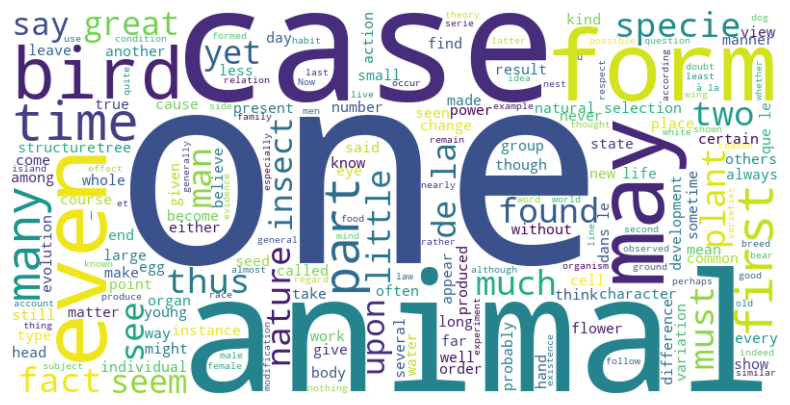

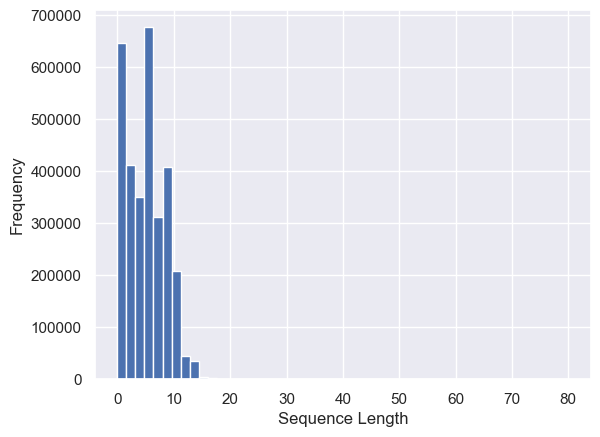

In [ ]:
# Create a config dictionary in order to change deep learning hyperparameters
config = {
    # 'subcategory': 'World War II',
    'subcategory': 'Biology',
    'dropout': 0.1,
    'seq_len': 32,
    'batch_size': 128,
    'd_model': 512,
    'h': 8,
    'N': 6,
    'd_ff': 2048,
    'num_epochs': 9,
    'learning_rate': 1e-5,
    'patience': 10,
    'r': 2,
    'transfer_learning': False,
}

# Create automated naming
suffix = '_TL' if config['transfer_learning'] else ''
subcategory = config["subcategory"]
subcategory = subcategory.replace(' ', '_')
config['model_path'] = f'./{subcategory}_LLM_{config["num_epochs"]}{suffix}.pt'
config['GAN_model_path'] = f"GAN_{config['model_path']}"
config['tokenizer_path'] = f'./{subcategory}_tokenizer.json'

# Load data into memory using project gutenberg's library
load_data_time = time.time()
txt_links, all_sentences = get_text_data(subcategory=config["subcategory"], logger=logger)
logger.info(f'Loading data took {time.time() - load_data_time:.2f} seconds')

# Run preliminary analytics on the text data
word_analytics(sentences=all_sentences)

# Instantiate a dictionary to track training metrics
train_info = {
    'train_losses': [],
    'val_losses': [],
    'learning_rates': [],
    'epochs': [],
    'best_val_loss': float('inf'),
    'patience_counter': 0,
}

# Train the chatbot
train_info = train_chatbot(raw_dataset=all_sentences, config=config, train_info=train_info, logger=logger)

In [ ]:
def plot_losses(train_info: dict):
    # Extract information from the train info dictionary populated during training
    train_losses = train_info['train_losses']
    learning_rates = train_info['learning_rates']
    epochs = train_info['epochs']

    # Create one plot with two axes to plot the training and validation losses on the same plot as the learning rate
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(epochs, train_losses, label='Training Loss', color='tab:blue')

    # With large datasets, inference validation is extremely tedious, so sometimes validation is skipped.
    if len(train_info['val_losses']) > 0:
        ax1.plot(epochs, train_info['val_losses'], label='Validation Loss', color='tab:orange')
        ax1.legend(loc='best')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Learning Rate', color='tab:red')
    ax2.plot(epochs, learning_rates, label='Learning Rate', color='tab:red')

    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title(f'Loss and Learning Rate over {max(train_info["epochs"])} Epochs')
    plt.show()

In [ ]:
# Run performance analytics
if len(train_info['train_losses']) == len(train_info['val_losses']) == len(train_info['learning_rates']) == len(train_info['epochs']):
    n_strings = len(train_info['dataset'].keys())
    preprocessed_sentences = [train_info['dataset'][i]['context'] for i in range(n_strings)] + [train_info['dataset'][n_strings - 1]['response']]
    word_analytics(sentences=preprocessed_sentences)
    plot_losses(train_info=train_info)

In [ ]:
# Communicate with the chatbot
chat(config=config)

# Maybe we can treat the chatbot like a generator in a GAN (General Adversarial Network) and use a Transformer discriminator to keep the architecture consistent and hope to get a more coherent model

In [ ]:
class TransformerGAN(pl.LightningModule):
    def __init__(self, config: dict):
        super().__init__()
        self.save_hyperparameters()
        self.lr = config['learning_rate']
        self.config = config
        self.tokenizer = get_or_build_tokenizer(config=config)
        self.vocab_size = len(self.tokenizer.get_vocab())
        self.generator = build_transformer(self.vocab_size, config['seq_len'], config['d_model'], config['N'],
                                           config['h'], config['dropout'], config['d_ff'])
        self.discriminator = self.build_discriminator()
        self.automatic_optimization = False

    def build_discriminator(self):
        # Discriminator is another Transformer model or a separate model based on transformer
        return Transformer(
            encoder=self.generator.encoder,
            decoder=self.generator.decoder,
            src_embed=self.generator.src_embed,
            tgt_embed=self.generator.tgt_embed,
            src_pos=self.generator.src_pos,
            tgt_pos=self.generator.tgt_pos,
            projection_layer=nn.Linear(self.generator.projection_layer.in_features, 1)  # Single output for real/fake
        )

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # Use generator to produce output
        return self.generator(src, tgt, src_mask, tgt_mask)

    @staticmethod
    def adversarial_loss(y_hat, y):
        return F.binary_cross_entropy_with_logits(y_hat, y)

    def training_step(self, batch, batch_idx):
        # Extract data from data loader
        src, tgt = batch['encoder_input'], batch['decoder_input']
        src_mask, tgt_mask = batch['encoder_mask'], batch['decoder_mask']

        # Access optimizers
        opt_g, opt_d = self.optimizers()

        # Sample noise
        z = torch.randn(src.size(0), self.config['seq_len'])
        z = z.type_as(src)

        # Zero out the generator gradient
        opt_g.zero_grad()

        # Generate fake responses
        generated_responses = self(z, tgt, src_mask, tgt_mask)

        # Train generator
        y_hat = self.discriminator(generated_responses, tgt, src_mask, tgt_mask)
        y = torch.ones(y_hat.size(0), 1)
        y = y.type_as(src)
        g_loss = self.adversarial_loss(y_hat, y)
        self.manual_backward(g_loss)
        opt_g.step()

        # Train discriminator
        opt_d.zero_grad()
        y_hat_real = self.discriminator(src, tgt, src_mask, tgt_mask)
        y_real = torch.ones(src.size(0), 1)
        y_real = y_real.type_as(src)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        y_hat_fake = self.discriminator(generated_responses.detach())
        y_fake = torch.zeros(src.size(0), 1)
        y_fake = y_fake.type_as(src)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        d_loss = (real_loss + fake_loss) / 2
        self.manual_backward(d_loss)
        opt_d.step()

        log_dict = {"g_loss": g_loss, "d_loss": d_loss}
        self.log_dict(log_dict)

    def validation_step(self, batch, batch_idx):
        # Extract data from data loader
        src, tgt = batch['encoder_input'], batch['decoder_input']
        src_mask, tgt_mask = batch['encoder_mask'], batch['decoder_mask']

        # Sample noise
        z = torch.randn(src.size(0), self.config['seq_len'])
        z = z.type_as(src)

        # Generate fake responses
        generated_responses = self(z, tgt, src_mask, tgt_mask)

        # Compute discriminator loss on real data
        y_hat_real = self.discriminator(src, tgt, src_mask, tgt_mask)
        y_real = torch.ones(y_hat_real.size(0), 1)
        y_real = y_real.type_as(src)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        # Compute discriminator loss on fake data
        y_hat_fake = self.discriminator(generated_responses.detach(), tgt, src_mask, tgt_mask)
        y_fake = torch.zeros(y_hat_fake.size(0), 1)
        y_fake = y_fake.type_as(src)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2

        # Compute generator loss
        y = torch.ones(generated_responses.size(0), 1)
        y = y.type_as(src)
        g_loss = self.adversarial_loss(generated_responses, y)

        self.log('val_g_loss', g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_d_loss', d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return {'val_g_loss': g_loss, 'val_d_loss': d_loss}

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)

        # Define the learning rate scheduler for generator
        scheduler_g = torch.optim.lr_scheduler.CosineAnnealingLR(opt_g, T_max=100)

        # Define the learning rate scheduler for discriminator
        scheduler_d = torch.optim.lr_scheduler.CosineAnnealingLR(opt_d, T_max=100)

        return [opt_g, opt_d], [scheduler_g, scheduler_d]

In [ ]:
def train_gan(config, raw_dataset):
    # Preprocess text data
    dataset = preprocess_text_data(dataset=raw_dataset, seq_len=config['seq_len'], logger=logger)

    # Get or build tokenizer
    tokenizer = get_or_build_tokenizer(config=config)

    # Split the dataset into training and validation sets and convert them into torch Dataset objects
    train_dataset, val_dataset = split_dataset(dataset=dataset, tokenizer=tokenizer, config=config, logger=logger)

    # Create Dataloader objects for the training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=custom_collate_fn, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=custom_collate_fn, pin_memory=True)

    # Create GAN model
    gan_model = TransformerGAN(config)

    # Initialize PyTorch Lightning trainer
    trainer = pl.Trainer(max_epochs=config['num_epochs'], devices=1 if torch.cuda.is_available() else 0)

    # Train the model
    trainer.fit(gan_model, train_loader, val_loader)
    torch.save(chatbot_gan.state_dict(), config['GAN_model_path'])
    return chatbot_gan

In [ ]:
chatbot_gan = train_gan(config=config, raw_dataset=all_sentences)

In [ ]:
def load_model(config: dict) -> TransformerGAN:
    # Create GAN model
    model = TransformerGAN(config=config)

    # Load the trained model
    checkpoint = torch.load(config['GAN_model_path'], map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    model.load_state_dict(checkpoint['state_dict'])

    return model


def chat_with_model(config: dict):
    model = load_model(config=config)
    model.eval()
    tokenizer = get_or_build_tokenizer(config=config)

    model.to(torch.device('cpu'))

    while True:
        user_input = input("You: ")
        if user_input.lower() == 'exit':
            break

        # Tokenize the input
        user_tokens = tokenizer.encode(user_input, return_tensors='pt')
        user_tokens = user_tokens[:, :config['seq_len'] - 2]  # Ensure it fits the sequence length

        # Create a fake target tensor
        tgt_tokens = torch.tensor([[config['vocab_size'] - 1]], dtype=torch.long)  # Start with [SOS] token
        tgt_tokens = tgt_tokens.repeat(1, config['seq_len'] - 1)  # Fill with [PAD] tokens

        # Create masks
        src_mask = (user_tokens != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(2)
        tgt_mask = torch.triu(torch.ones((config['seq_len'], config['seq_len']), dtype=torch.uint8),
                              diagonal=1).unsqueeze(0)

        with torch.no_grad():
            output = model(user_tokens, tgt_tokens, src_mask, tgt_mask)

        # Get the predicted tokens
        predicted_tokens = torch.argmax(output, dim=-1).squeeze().tolist()

        # Decode the predicted tokens
        response = tokenizer.decode(predicted_tokens, skip_special_tokens=True)
        print(f"Bot: {response}")

In [ ]:
chat_with_model(config=config)